In [27]:
import geopandas as gpd
import pystac_client
import stackstac
import matplotlib.pyplot as plt
import planetary_computer
import xarray as xr
import numpy as np
import rioxarray
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [28]:
aoi = gpd.read_file('../../2_data/Koumbia_db/Koumbia_JECAM_2018-20-21.shp')
aoi_4326 = aoi.to_crs('EPSG: 4326')
bbox = aoi_4326.total_bounds
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
year = ['2018', '2020', '2021']

In [29]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )

In [30]:
s2_search_2018 = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox= bbox,
        datetime= year[2] + '-01-01/' + year[2] + '-12-31',
        query={
                #'eo:cloud_cover': {"lt": 100}, 
                's2:nodata_pixel_percentage': {'lt': 50},
                's2:mgrs_tile': {'eq': '30PVT'}},
        )
item2018 = s2_search_2018.item_collection()

In [31]:
len(item2018)

71

In [32]:
stack = stackstac.stack(item2018, resolution = 10, bounds = aoi.total_bounds, chunksize= (len(item2018), 1, 'auto', 'auto'), xy_coords= 'center')

/Users/edgar/opt/anaconda3/envs/GeoDS/lib/python3.11/site-packages/stackstac/accumulate_metadata.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(


In [33]:
stack.sel(band = bands)

<xarray.DataArray 'stackstac-8843fa375dbb3959289877d09ba0ba56' (time: 71,
                                                                band: 10,
                                                                y: 4513, x: 5183)>
dask.array<getitem, shape=(71, 10, 4513, 5183), dtype=float64, chunksize=(71, 1, 453, 520), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2021-01-04...
    id                                       (time) <U54 'S2B_MSIL2A_20210104...
  * band                                     (band) <U7 'B02' 'B03' ... 'B12'
  * x                                        (x) float64 4.026e+05 ... 4.544e+05
  * y                                        (y) float64 1.257e+06 ... 1.212e+06
    s2:saturated_defective_pixel_percentage  float64 0.0
    ...                                       ...
    title                                    (band) <U37 'Band 2 - Blue - 10m...
    proj:shape                               (band) object [10980, 10980] ......
    common_name                              (band) object 'blue' ... 'swir22'
    center_wavelength                        (band) object 0.49 0.56 ... 2.19
    full_width_half_max                      (band) object 0.098 0.045 ... 0.242
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(402570, 1212060, 454400, 1257...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 402570.00|\n| 0.00,-10.00, 1257190.00|\n| 0.0...
    resolution:  10

In [34]:
petite_bbox = [415000, 1240000, 415000+1000, 1240000+1000]
stack2018 = stackstac.stack(item2018, resolution = 10, bounds = petite_bbox, chunksize= (69, 1, 100, 100), xy_coords= 'center')
stack2018 = stack2018.drop_duplicates(dim = 'time')
SCL = stack2018.sel(band = 'SCL')
stack2018 = stack2018.sel(band = bands)

cirrus = xr.where(SCL == 10, 1, 0) # cirrus pixels, binary mask 0, 1
highclouds = xr.where(SCL == 9, 1, 0) # High probability clouds, binary mask 0, 1
medclouds = xr.where(SCL == 8, 1, 0) # Medium probability clouds, binary mask 0, 1
unclass = xr.where(SCL == 7, 1, 0) # unclassified pixels, binary mask 0, 1
shaclouds = xr.where(SCL == 3, 1, 0) # Cloud shadows, binary mask 0, 1
saturated = xr.where(SCL == 1, 1, 0) # saturated pixels, binary mask 0, 1

## mannually check quality of final interpolation

mask = highclouds + medclouds + shaclouds + saturated + cirrus + unclass # Mask, binary mask 0, 1
maskedstack = stack2018.where(mask == 0, np.nan)

/Users/edgar/opt/anaconda3/envs/GeoDS/lib/python3.11/site-packages/stackstac/accumulate_metadata.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(


In [35]:
maskedstack

<xarray.DataArray 'stackstac-97c15dc4a9233227776f71ed5491626d' (time: 68,
                                                                band: 10,
                                                                y: 100, x: 100)>
dask.array<where, shape=(68, 10, 100, 100), dtype=float64, chunksize=(67, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                     (time) datetime64[ns] 2021-01-04...
    id                                       (time) <U54 'S2B_MSIL2A_20210104...
  * band                                     (band) <U7 'B02' 'B03' ... 'B12'
  * x                                        (x) float64 4.15e+05 ... 4.16e+05
  * y                                        (y) float64 1.241e+06 ... 1.24e+06
    s2:saturated_defective_pixel_percentage  float64 0.0
    ...                                       ...
    s2:datatake_type                         <U8 'INS-NOBS'
    s2:granule_id                            (time) <U62 'S2B_OPER_MSI_L2A_TL...
    s2:mean_solar_azimuth                    (time) float64 146.9 ... 148.0
    sat:relative_orbit                       int64 108
    proj:bbox                                (band) object [399960.0, 1190220...
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(415000, 1240000, 416000, 1241...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 415000.00|\n| 0.00,-10.00, 1241000.00|\n| 0.0...
    resolution:  10

In [36]:
corr = 5 - maskedstack.time.dt.dayofyear.values[0]

In [37]:
pc_idx = (maskedstack.time.dt.dayofyear.values + corr) / 5
missing_idx = np.setdiff1d(np.arange(5, 370, 5) / 5, pc_idx)
n_missing = missing_idx.shape[0]


In [38]:

pcdata = np.array(maskedstack.values)
n_bands = pcdata.shape[1]
n_y = pcdata.shape[2]
n_x = pcdata.shape[3]
nandata = np.array([np.nan]*n_missing*n_bands*n_y*n_x).reshape(n_missing, n_bands, n_y, n_x)
completets = np.zeros((73, n_bands, n_y, n_x))


In [39]:

for n, i in enumerate(pc_idx):
    completets[int(i)-1, :, :, :] = pcdata[n, :, :, :]

In [40]:
for n, i in enumerate(missing_idx):
    completets[int(i)-1, :, :, :] = nandata[n, :, :, :]

In [41]:
x = maskedstack.indexes['x']
y = maskedstack.indexes['y']
band = maskedstack.indexes['band']
dates2018 = [pd.to_datetime(doy-1, unit='D', origin=str(2018)) for doy in np.arange(5, 370, 5)]
time = pd.Index(dates2018, name = 'time')

In [51]:
temp2018 = xr.DataArray(
    data = completets,
    coords=dict(time = time,
                 band = band,
                 y = y,
                 x = x)
    
    )
temp2018._copy_attrs_from(maskedstack)

In [52]:
temp2018

<xarray.DataArray (time: 73, band: 10, y: 100, x: 100)>
array([[[[ 728.,  657.,  610., ...,  549.,  569.,  504.],
         [ 709.,  664.,  608., ...,  398.,  527.,  498.],
         [ 709.,  692.,  662., ...,  503.,  545.,  556.],
         ...,
         [ 744.,  676.,  655., ...,  709.,  581.,  517.],
         [ 796.,  774.,  700., ...,  727.,  583.,  827.],
         [ 837.,  860.,  765., ...,  678.,  673.,  647.]],

        [[ 985.,  971.,  854., ...,  800.,  790.,  777.],
         [1021.,  935.,  818., ...,  578.,  724.,  741.],
         [ 977.,  973.,  955., ...,  736.,  786.,  805.],
         ...,
         [1060., 1005.,  984., ..., 1050.,  867.,  829.],
         [1156., 1134., 1076., ...,  930.,  970., 1180.],
         [1238., 1220., 1184., ..., 1140., 1019., 1038.]],

        [[1482., 1374., 1288., ..., 1200., 1298., 1150.],
         [1544., 1418., 1290., ...,  764., 1148., 1098.],
         [1566., 1506., 1442., ...,  918., 1210., 1172.],
         ...,
...
         ...,
         [3583., 3583., 3541., ..., 3526., 3488., 3488.],
         [3614., 3614., 3575., ..., 3898., 3693., 3693.],
         [3614., 3614., 3575., ..., 3898., 3693., 3693.]],

        [[4363., 4363., 4332., ..., 4072., 4305., 4305.],
         [4363., 4363., 4332., ..., 4072., 4305., 4305.],
         [4369., 4369., 4289., ..., 4297., 4458., 4458.],
         ...,
         [5215., 5215., 5135., ..., 4275., 4000., 4000.],
         [5367., 5367., 5294., ..., 4269., 4268., 4268.],
         [5367., 5367., 5294., ..., 4269., 4268., 4268.]],

        [[3226., 3226., 3196., ..., 3405., 3434., 3434.],
         [3226., 3226., 3196., ..., 3405., 3434., 3434.],
         [3243., 3243., 3177., ..., 3435., 3599., 3599.],
         ...,
         [4217., 4217., 4353., ..., 3487., 3216., 3216.],
         [4494., 4494., 4421., ..., 3404., 3488., 3488.],
         [4494., 4494., 4421., ..., 3404., 3488., 3488.]]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-05 2018-01-10 ... 2018-12-31
  * band     (band) object 'B02' 'B03' 'B04' 'B05' ... 'B08' 'B8A' 'B11' 'B12'
  * y        (y) float64 1.241e+06 1.241e+06 1.241e+06 ... 1.24e+06 1.24e+06
  * x        (x) float64 4.15e+05 4.15e+05 4.15e+05 ... 4.16e+05 4.16e+05
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(415000, 1240000, 416000, 1241...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 415000.00|\n| 0.00,-10.00, 1241000.00|\n| 0.0...
    resolution:  10

In [53]:
interp2018 = temp2018.interpolate_na(dim="time", method="linear", use_coordinate = 'time')


In [55]:
interp2018.data = interp2018.data.astype(np.uint16)

In [56]:
interp2018

<xarray.DataArray (time: 73, band: 10, y: 100, x: 100)>
array([[[[ 728,  657,  610, ...,  549,  569,  504],
         [ 709,  664,  608, ...,  398,  527,  498],
         [ 709,  692,  662, ...,  503,  545,  556],
         ...,
         [ 744,  676,  655, ...,  709,  581,  517],
         [ 796,  774,  700, ...,  727,  583,  827],
         [ 837,  860,  765, ...,  678,  673,  647]],

        [[ 985,  971,  854, ...,  800,  790,  777],
         [1021,  935,  818, ...,  578,  724,  741],
         [ 977,  973,  955, ...,  736,  786,  805],
         ...,
         [1060, 1005,  984, ..., 1050,  867,  829],
         [1156, 1134, 1076, ...,  930,  970, 1180],
         [1238, 1220, 1184, ..., 1140, 1019, 1038]],

        [[1482, 1374, 1288, ..., 1200, 1298, 1150],
         [1544, 1418, 1290, ...,  764, 1148, 1098],
         [1566, 1506, 1442, ...,  918, 1210, 1172],
         ...,
...
         ...,
         [3583, 3583, 3541, ..., 3526, 3488, 3488],
         [3614, 3614, 3575, ..., 3898, 3693, 3693],
         [3614, 3614, 3575, ..., 3898, 3693, 3693]],

        [[4363, 4363, 4332, ..., 4072, 4305, 4305],
         [4363, 4363, 4332, ..., 4072, 4305, 4305],
         [4369, 4369, 4289, ..., 4297, 4458, 4458],
         ...,
         [5215, 5215, 5135, ..., 4275, 4000, 4000],
         [5367, 5367, 5294, ..., 4269, 4268, 4268],
         [5367, 5367, 5294, ..., 4269, 4268, 4268]],

        [[3226, 3226, 3196, ..., 3405, 3434, 3434],
         [3226, 3226, 3196, ..., 3405, 3434, 3434],
         [3243, 3243, 3177, ..., 3435, 3599, 3599],
         ...,
         [4217, 4217, 4353, ..., 3487, 3216, 3216],
         [4494, 4494, 4421, ..., 3404, 3488, 3488],
         [4494, 4494, 4421, ..., 3404, 3488, 3488]]]], dtype=uint16)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-05 2018-01-10 ... 2018-12-31
  * band     (band) object 'B02' 'B03' 'B04' 'B05' ... 'B08' 'B8A' 'B11' 'B12'
  * y        (y) float64 1.241e+06 1.241e+06 1.241e+06 ... 1.24e+06 1.24e+06
  * x        (x) float64 4.15e+05 4.15e+05 4.15e+05 ... 4.16e+05 4.16e+05
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(415000, 1240000, 416000, 1241...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 415000.00|\n| 0.00,-10.00, 1241000.00|\n| 0.0...
    resolution:  10

In [57]:
minmax_bandtime = interp2018.quantile([0.02, 0.98], dim=['x', 'y'])
norm2018 = (interp2018 - minmax_bandtime[0, :, :]) / (minmax_bandtime[1, :, :] - minmax_bandtime[0, :, :])
norm2018_2 = norm2018.where(norm2018 > 0, 0, drop=True)
norm2018_2 = norm2018_2.where(norm2018_2 < 1, 1, drop=True)

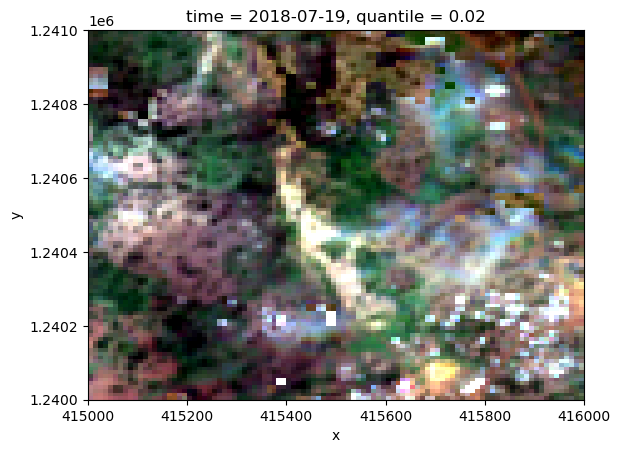

In [58]:
norm2018_2[39,:, :, :].sel(band = ['B04', 'B03', 'B02']).plot.imshow(rgb="band", robust=True)

In [79]:
from dask.distributed import Client, LocalCluster, Lock
from dask.utils import SerializableLock

In [138]:
interp2018[:, 0, :, :].rio.to_raster("./testimages/test_center2.tif")

In [86]:
for t in tqdm(np.arange(0, 73, 1)):
    for b in np.arange(0, 10, 1):
        norm2018_2[t, b, :, :].rio.to_raster("./testimages/s2_{}_{}.tif".format(time[t].strftime('%Y%m%d'), bands[b]))